In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import xarray as xr

from pprint import pprint
import hhclusters

import utils

from importlib import reload
reload(utils)

<module 'utils' from '/home/jungyoung/Project/hh_neuralnet/dynamics_clustering/utils.py'>

In [188]:
features.key

<xarray.DataArray 'key' (key: 16)>
array(['chi', 'cv', 'frs_m', 'ac2p_large', 'tlag_large', 'ac2p_1st',
       'tlag_1st', 'pwr_large_ft', 'tlag_large_ft', 'pwr_1st_ft',
       'tlag_1st_ft', 'cc1p', 'tlag_cc', 'leading_ratio', 'leading_ratio(abs)',
       'dphi'], dtype=object)
Coordinates:
  * key      (key) object 'chi' 'cv' 'frs_m' ... 'leading_ratio(abs)' 'dphi'

In [13]:
# set target files
fname_features = "../three_pop_mpi/simulation_data/post_inv.nc"
fname_clusters = "./data/cluster_id_sub.nc"

# fname_features = "../mono_pop_mpi/simulation_data/postdata_fast_inv.nc"
# fname_clusters = "./data/cluster_id_mfast.nc"

# Read file
features = xr.load_dataarray(fname_features)
clusters = xr.load_dataset(fname_clusters)

nums, num_total = [], 1
for k in ("alpha", "beta", "rank", "w"):
    nums.append(len(clusters.coords[k]))
    num_total *= nums[-1]
print(nums)

# target_keys = ("chi", "cv", "frs_m", "ac2p_large", "tlag_large", "ac2p_1st", "tlag_1st", "cc1p", "tlag_cc", "leading_ratio", "leading_ratio(abs)") # time
target_keys = ("chi", "cv", "frs_m", "ac2p_large", "fp_large", "ac2p_1st", "fp_1st", "cc1p", "tlag_cc", "leading_ratio", "leading_ratio(abs)")
include_var = (True, False, True, True, True, True, True, True, True, False, False)
# inverse_mean = (False, False, False, False, True, False, True, False, False, False, False)
num_pops = (2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1)

[15, 15, 3, 16]


In [10]:
features.key

<xarray.DataArray 'key' (key: 16)>
array(['chi', 'cv', 'frs_m', 'ac2p_large', 'fp_large', 'ac2p_1st', 'fp_1st',
       'pwr_large_ft', 'fp_large_ft', 'pwr_1st_ft', 'fp_1st_ft', 'cc1p',
       'tlag_cc', 'leading_ratio', 'leading_ratio(abs)', 'dphi'], dtype=object)
Coordinates:
  * key      (key) object 'chi' 'cv' 'frs_m' ... 'leading_ratio(abs)' 'dphi'

In [5]:
# collect data set
dataset = np.zeros((num_total, len(include_var), 2, 2)) # mean/var, pop_types

nstack = 0
for na in range(nums[0]):
    for nb in range(nums[1]):
        for nr in range(nums[2]):
            for nw in range(nums[3]):
                val = features.sel(key=list(target_keys)).isel(alpha=na, beta=nb, rank=nr, w=nw)
                dataset[nstack,...,0] = val.sel(pop="F", type=["mean", "var"])
                dataset[nstack,...,1] = val.sel(pop="S", type=["mean", "var"])
                nstack += 1

for nk in range(len(target_keys)):
    if num_pops[nk] == 1:
        dataset[:,nk,:,1] = np.nan
    # if inverse_mean[nk]:
    #     dataset[:,nk,0,:] = 1/dataset[:,nk,0,:]
    if not include_var[nk]:
        dataset[:,nk,1,:] = np.nan
                
# get cid and silhouette value
cid_flat = clusters.cluster_id.data.flatten()
sval_flat = clusters.sval.data.flatten()

In [6]:
# align dataset
align_dataset = np.zeros_like(dataset)

nstack = 0
for cid in clusters.id_set:
    is_in = cid_flat == cid
    
    nin = np.sum(is_in)
    data_sub = dataset[is_in,...]
    sval_sub = sval_flat[is_in]
    
    # sort value
    id_sort = np.argsort(sval_sub)[::-1]
    
    align_dataset[nstack:nstack+nin,...] = data_sub[id_sort,...]
    nstack += nin

In [70]:
from copy import copy

# flat dataset
flat_dataset = []
flat_labels = []

key_pops = ("F", "S")
# key2lb_inv = {"tlag_1st": "f_1",
#               "tlag_large": "f_2",
#               "fp_1st": "f_1",
#               "fp_large": "f_2"}
key2lb_inv = {"fp_1st": "f_1",
              "fp_large": "f_M"}

for nk in range(len(target_keys)):
    key = target_keys[nk]
    if key == "cv":
        lb = "cv"
    elif "fp" in key:
        lb = key2lb_inv[key]
    else:
        lb = utils.key2lb[key]
    
    for npop in range(num_pops[nk]):
        lb_pop = copy(lb)
        if num_pops[nk] > 1:
            # lb = target_keys[nk] + key_pops[npop]
            # lb_pop = lb + key_pops[npop]
            lb_pop = "%s^{%s}"%(lb_pop, key_pops[npop])
        
        for nv in range(2):
            if not include_var[nk] and nv == 1: continue
            if "\eta" in lb_pop or "\zeta" in lb_pop:
                lb2 = lb_pop
            elif nv == 0:
                lb2 = "\\leftangle %s \\rightangle"%(lb_pop)
            else:
                lb2 = "\\sigma [%s]"%(lb_pop)
            # print(lb2)
                
            x = align_dataset[:,nk,nv,npop]
            assert not np.any(np.isnan(x))
            
            flat_dataset.append(x)
            flat_labels.append(r"$%s$"%(lb2))

flat_dataset = np.swapaxes(flat_dataset, 1, 0)

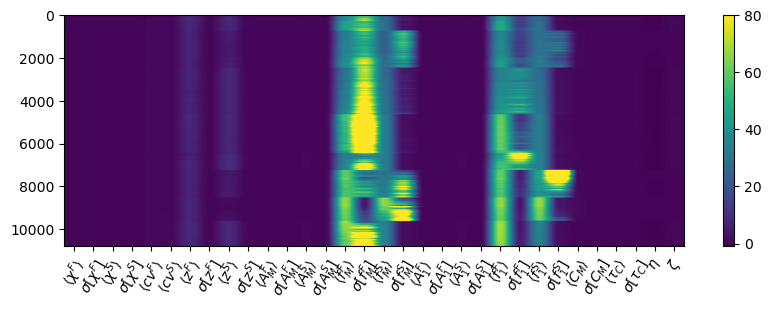

In [72]:
plt.figure(figsize=(10, 3))
plt.imshow(flat_dataset, aspect="auto", vmax=80)
plt.xticks(np.arange(flat_dataset.shape[1]), labels=flat_labels, rotation=60)
plt.colorbar()
plt.show()

In [220]:
target_keys = ("chi", "cv", "frs_m", "ac2p_large", "fp_large", "ac2p_1st", "fp_1st", "cc1p", "tlag_cc", "leading_ratio", "leading_ratio(abs)")

(10800, 32)

In [ ]:
pop_flat_dataset = []
pop_flat_labels = []

for nk in range(len(target_keys)):
    key = target_keys[nk]
    if key == "cv":
        lb = "cv"
    elif "fp" in key:
        lb = key2lb_inv[key]
    else:
        lb = utils.key2lb[key]

In [ ]:
rmin = [0 for _ in range(len(target_keys))]
rmax = [1, 1, 12, 2

In [295]:
from copy import copy

# flat dataset
data_mean = [[], []]
data_std  = [[], []]
data_labels = []

key_pops = ("F", "S")
key2lb_inv = {"fp_1st": "f_1",
              "fp_large": "f_M"}

N = align_dataset.shape[0]

for nk in range(len(target_keys)):
    key = target_keys[nk]
    if key == "cv":
        lb = "cv"
    elif "fp" in key:
        lb = key2lb_inv[key]
    else:
        lb = utils.key2lb[key]
    data_labels.append(r"$%s$"%(lb))
    

data_mean = np.swapaxes(align_dataset[:,:,0,:], 0, 2)
# data_std  = np.swapaxes(align_dataset[:,:,1,:], 0, 2)
# data_std[np.isnan(data_std)] = 0

# data_mean = np.median(data_mean, axis=2)
# data_bot = np.percentile(data_mean, 5, axis=2)
# data_top = np.percentile(data_mean, 95, axis=2)

# data_bot[1,7:] = data_bot[0,7:]
# data_top[1,7:] = data_top[0,7:]

In [326]:
N = 11
rmin = [0, 0,  0, 0,  0, 0,  0, 0, -0.01, -1, 0]
rmax = [1, 1, 10, 1, 90, 1, 90, 1,  0.01,  1, 1]

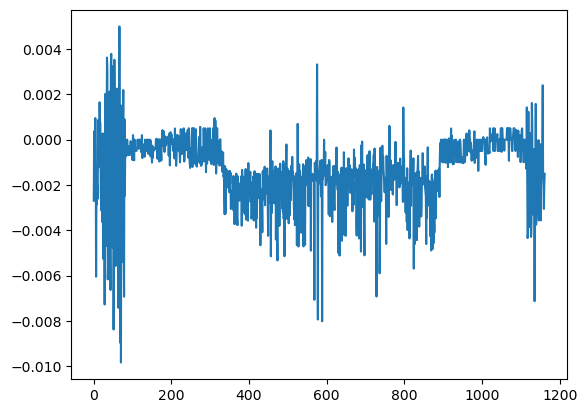

In [325]:
plt.plot(data_sub[0,-3,:])

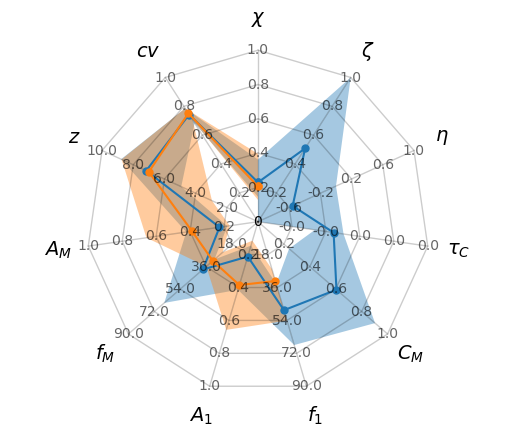

In [327]:
cid = 8

data_sub = data_mean[...,cid_flat==cid]
rmid = np.median(data_sub, axis=2)
rbot = np.percentile(data_sub, 10, axis=2)
rtop = np.percentile(data_sub, 90, axis=2)


fig = RadarFigure(N, rmin, rmax)
fig.set_labels(data_labels)

for n in range(2):
    c = 'C%d'%(n)
    fig.fill(rbot[n], rtop[n], color=c)
    fig.plot(rmid[n], '.-', color=c, markersize=10)

In [252]:
class RadarFigure:
    def __init__(self, num_category, 
                 xmin, xmax,
                 figsize=None, dpi=None):
        
        assert num_category == len(xmin)
        assert num_category == len(xmax)
        
        # self.fig, self.ax = plt.subplots(figsize=figsize, dpi=dpi, subplot_kw={"projection": "polar"})
        self.fig, self.ax = plt.subplots(figsize=figsize, dpi=dpi)
        self.N = num_category
        self.agl = np.arange(num_category) * 2*np.pi/self.N + np.pi/2
        self.xmin = xmin
        self.xmax = xmax
        self.nticks = 5
        self._draw_tickline()
        self._set_ax()
        self._set_ticks()
        plt.axis("off")
        
    def _set_ax(self):
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis("equal")
        
    def _draw_tickline(self):
        
        agl = np.concatenate((self.agl, [self.agl[0]]))
        num = self.nticks
        for n in range(num+1):
            r = n/num
            plt.plot(r*np.cos(agl), r*np.sin(agl), color='k', alpha=0.2, lw=1)
        # r = 1.1
        # plt.plot(r*np.cos(agl), r*np.sin(agl), 'k', lw=1, alpha=0.2)

        for a in self.agl:
            plt.plot([0, r*np.cos(a)], [0, r*np.sin(a)], color='k', alpha=0.2, lw=1)
            
    def _set_ticks(self):
        num = self.nticks
        for na, a in enumerate(self.agl):
            r0 = self.xmin[na]
            dr = (self.xmax[na] - r0)/self.nticks
            for n in range(1, num+1):
                rtxt = "%.1f"%(r0+dr*n)
                r = n/num
                x, y = r*np.cos(a), r*np.sin(a)
                plt.text(x, y, rtxt, color='k', va="center", ha="center", alpha=0.6)
        plt.text(0, 0, "0", color='k', va="center", ha="center")
                
            
    def set_labels(self, labels, fontsize=14):
        assert len(labels) == self.N
        for a, txt in zip(self.agl, labels):
            plt.text(1.18*np.cos(a), 1.18*np.sin(a), txt, fontsize=fontsize,
                     color='k', ha="center", va="center")
        
    def plot(self, r, *args, **kwargs):
        assert len(r) == self.N
        rset = []
        for n in range(self.N):
            rset.append((r[n]-self.xmin[n])/(self.xmax[n]-self.xmin[n]))
        rset = connect_e2e(rset)
        agl  = connect_e2e(self.agl)
        
        plt.plot(rset*np.cos(agl), rset*np.sin(agl), *args, **kwargs)
        
    def fill(self, rmin, rmax, color="C0", alpha=0.4):
        
        _rmin = connect_e2e(rmin)
        _rmax = connect_e2e(rmax)
        agl = connect_e2e(self.agl)
        
        r0 = np.array(self.xmin)
        rw = np.array(self.xmax) - r0
        r0 = connect_e2e(r0)
        rw = connect_e2e(rw)
        
        patches = []
        for n in range(self.N):
            r = [(_rmin[n]-r0[n])/rw[n],
                 (_rmax[n]-r0[n])/rw[n],
                 (_rmax[n+1]-r0[n+1])/rw[n+1],
                 (_rmin[n+1]-r0[n+1])/rw[n+1]]
            a = [agl[n], agl[n], agl[n+1], agl[n+1]]
            r = np.array(r)
            p = Polygon(np.transpose([np.cos(a), np.sin(a)])*r[:,None], closed=True)
            patches.append(p)
        
        pax = PatchCollection(patches, alpha=alpha)
        pax.set_facecolor(color)
        self.ax.add_collection(pax)
        
    def show(self):
        self.fig.show()
    
    def __call__(self):
        pass
    
    
def connect_e2e(arr):
    return np.concatenate((arr, [arr[0]]))

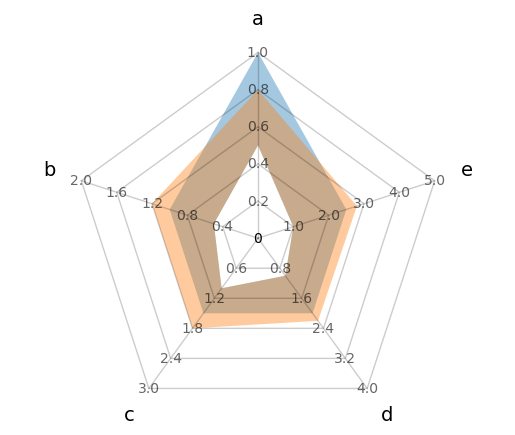

In [219]:
fig = RadarFigure(5, [0 for _ in range(5)],
                  [1, 2, 3, 4, 5])
fig.set_labels(["a", "b", "c", "d", "e"])
fig._set_ticks()
fig.fill([0.5,0.5,1,1,1], [1, 1, 1.5, 2, 2.5], color='C0')
fig.fill([0.5,0.5,1,1,1], [0.8, 1.2, 1.8, 2.2, 2.8], color='C1')